In [ ]:
from artifice.network import NN
from artifice.helper import apply_random_permutation, one_hot_encode, load_model

# Example on How to Build a Basic Neural Network:

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
""" Code written by William Bidle and Ilana Zane """

__version__ = "dev"

import os
import pickle
from typing import List, Union, Tuple

import numpy as np
import matplotlib.pyplot as plt
import sympy
from tqdm import tqdm

from artifice.loss_functions import (
    MeanAbsoluteError,
    MeanAbsolutePercentError,
    MeanLogSquaredError,
    MeanSquaredError,
    PoissonError,
    BinaryCrossEntropy,
)
from artifice.activation_functions import (
    Sigmoid,
    Tanh,
    ReLU,
    Linear,
)


class NN:

    """
    Defines a neural network.

    :param layer_sequence: A list containing the nodes per layer and correcponding activation
    functions between layers.
    :param loss_function: The desired loss function to be used.
    """

    def __init__(self, layer_sequence: list, loss_function: str):

        valid_loss_functions = {
            "MSE" : MeanSquaredError(),
            "MAE" : MeanAbsoluteError(),
            "MAPE" : MeanAbsolutePercentError(),
            "MLSE" : MeanLogSquaredError(),
            "Poisson" : PoissonError(),
            "BCE" : BinaryCrossEntropy(),
        }

        valid_activation_functions = {
            "relu" : ReLU(),
            "sigmoid" : Sigmoid(),
            "tanh" : Tanh(),
            "linear" : Linear(),
        }


        # Separate out the layer information and activations (every other element)
        layers = layer_sequence[::2]
        activation_funcs = layer_sequence[1::2]

        # Check if valid layer elements activation functions
        assert all(isinstance(item, int) for item in layers), "Invalid Layer Sequence!"
        for activation_func in activation_funcs:
            assert activation_func in valid_activation_functions, f"Invalid activation function '{activation_func}'."

        # Set the layers
        layers = np.array(layer_sequence[::2], dtype=int)

        # initialize the weights based off of the desired layer sequence
        self.weights = self.__initialize_weights(layers)

        # initialize the 'activation_funcs' property
        self.activation_funcs = []

        # initialize each declared activation functions between layers
        for activation_func in activation_funcs:
            self.activation_funcs.append(valid_activation_functions[activation_func])


        # initialize the loss_func
        self.loss_func = valid_loss_functions[loss_function]

        # initialize the loss_func_label (used in plotting for now)
        self.loss_func_label = loss_function

        # initialize the *training_err* property (will be set later once the model is trained)
        self.training_err = None

    def __initialize_weights(self, layers: np.ndarray) -> List[np.ndarray]:

        """
        Initialize the weights of the network.

        :params layers: An array containing the layer information of the network.
        :returns weights: List containing the 2D weight arrays between the different layers.
        """

        layers_reorganized = np.flip(
            layers.repeat(2)[1:-1].reshape(len(layers) - 1, 2), axis=1
        )

        # initialize the list of the weights between different layers
        weights = []

        for layer_reorganized in layers_reorganized:
            # include bias vector with the '+ 1'
            weight = np.random.randn(layer_reorganized[0], layer_reorganized[1] + 1)

            # HE initialization for weights
            weights.append(weight * np.sqrt(2 / layer_reorganized[1]))

        return weights

    def __update_weights(
        self, weights: List[np.ndarray], layer_values: List[List], _label_: np.ndarray
    ) -> Tuple[List[np.ndarray], List[np.ndarray]]:

        """
        Update the weights of the network.

        :params weights: List containing the 2D weight arrays between the different layers.
        :params layer_values: List containing the values of each layer for a given input value.
        :params _label_: Array representation for the current label, usually one hot ecoded.
        :returns weight_updates: List of updated 2D weight arrays between the different layers.
        :returns weights: List of original 2D weight arrays between the different layers.
        """

        # get the list of desired activation functions
        activations = self.activation_funcs

        # make a copy of the weights so they aren't changed
        weight_updates = weights.copy()

        # blue in notes
        blue = np.diag(self.loss_func.evaluate(layer_values[-1], _label_, diff=True))

        # need to add an extra component to input for bias
        layer_output = np.dot(weights[-1], np.concatenate((layer_values[-2], [1])))

        # red in notes
        red = activations[-1].evaluate(layer_output, diff=True)

        # index through each weight (work backwards)
        for i in range(len(weights), 0, -1):

            # pink in notes
            pink = np.concatenate((layer_values[i - 1], [1]))

            # first two terms in gradient
            grad = np.matmul(blue, np.outer(red, pink))

            # look forwards through each weight (only if there are forward weights)
            for j in range(len(weights), i, -1):

                # orange in notes
                orange = np.transpose(weights[j - 1])

                # green in notes
                green = np.diag(
                    activations[j - 1].evaluate(
                        np.dot(
                            weights[j - 2],
                            np.concatenate((layer_values[j - 2], [1])),
                        ),
                        diff=True,
                    )
                )

                # add on the bias vector to make sure dimensions work properly
                bias_vec = np.ones((len(green), 1))

                # incorperate the bias
                green = np.hstack((green, bias_vec))

                # now multiply the rest to grad
                grad = np.matmul(green, np.matmul(orange, grad))

            # record the change in weight
            weight_updates[i - 1] = grad

        return weight_updates, weights

    def get_network_outputs(
        self, weights: List[np.ndarray], _input_: np.ndarray
    ) -> np.ndarray:
        """
        Initialize the weights of the network.

        :params weights: List containing the 2D weight arrays between the different layers.
        :params _inputs_: Input layer to the network.
        :returns network_outputs: Output layer of the network.
        """

        # get the list of desired activation functions
        activations = self.activation_funcs

        # add the first layer to the list
        current_layer = _input_
        network_outputs = [current_layer]

        for index, weight in enumerate(weights):

            # need to add an extra component to input for bias
            layer_output = np.dot(weight, np.concatenate((current_layer, [1])))

            current_layer = activations[index].evaluate(layer_output, diff=False)

            network_outputs.append(current_layer)

        return network_outputs

    def compute_error(self, _result_: np.ndarray, _label_: np.ndarray) -> float:
        """
        Compute the error between the neural network's output and expected value.

        :params _result_: Output layer of the network.
        :params _label_: Expected result.
        :returns error: The error of the network.
        """
        error = self.loss_func.evaluate(_result_, _label_, diff=False)

        return error

    def train(  # pylint: disable=too-many-arguments, too-many-locals
        self, x_train, y_train, batch_size=1, epochs=1, epsilon=1, visualize=False
    ) -> None:
        """
        Train a model.

        :params x_train:
        :params y_train:
        :params batch_size:
        :params epochs:
        :params epsilon:
        :params visualize:
        """

        weights = self.weights  # get the list of weights

        error_list = []

        counter = 0  # keep track of the current iteration

        weights_list = (
            {}
        )  # create a dictionary to keep track of the weight updates (batch size)

        # just a temporary blank array since training hasn't begun yet
        for i in range(len(weights)):
            weights_list[i] = []

        for i in range(epochs):

            # iterate through the inputs and labels
            for _input_, _label_ in tqdm(
                zip(x_train, y_train), total=len(x_train), desc=f"Epoch {str(i + 1)}"
            ):

                network_output = self.get_network_outputs(
                    weights, _input_
                )  # the current network output

                error = self.compute_error(network_output[-1], _label_)

                weight_updates, weights = self.__update_weights(
                    weights, network_output, _label_
                )

                for j in range(len(weights)):
                    weights_list[j].append(weight_updates[j])

                counter += 1

                if (counter) % batch_size == 0:
                    for index, weight in enumerate(weights):

                        weights[index] = weight - epsilon * np.average(
                            np.array(weights_list[index]), axis=0
                        )
                        weights_list[index] = []

                error_list.append(error)

            self.weights = weights
            self.training_err = error_list

        if visualize is True:
            _, ax = plt.subplots(figsize=(12, 6))

            ax.plot(self.training_err)  # to visualize error over time

            ax.set_xlabel("Training Sample", fontsize=14)
            ax.set_ylabel(f"{self.loss_func_label} Error", fontsize=14)

            ax.grid(linestyle="--")

            plt.show()

    def evaluate(self, x_test):
        """
        Evaluate a model.

        :params x_test:
        :returns results:
        """

        results = []

        for _input_ in tqdm(x_test, desc="Evaluating Test Data", total=len(x_test)):
            # the current network output
            network_output = self.get_network_outputs(self.weights, _input_)
            results.append(network_output[-1])

        return results

    def save_model(self, out_dir: str, filename: str) -> None:
        """
        Save a model.

        :params filename:
        """

        # Enforce trailing backslash to directory
        out_dir = os.path.join(out_dir, "")

        # Check if out_dir exists
        if not os.path.exists(out_dir):
            raise ValueError(f"Invalid path: {out_dir}.")

        save_path = out_dir + filename

        to_save = [
            self.weights,
            self.activation_funcs,
        ]  # save both the activations and weights
        with open(save_path, "wb") as fp:  # save the weights and activations
            pickle.dump(to_save, fp)

        print()
        print(f"Model saved at '{save_path}'")
        print()


In [16]:
layer_sequence = [1,'relu', 2, 'sigmoid', 3]
loss_function = 'MSE'

nn = NN(layer_sequence, loss_function)

# Avaliable Class Properties
print('current weights:\n', nn.weights, '\n')
print('current activation functions:\n', nn.activation_funcs, '\n')
print('current loss function:\n', nn.loss_func_label, ':', nn.loss_func, '\n')
print('traing error:\n', nn.training_err, '\n')

current weights:
 [array([[-0.38998289, -1.12108658],
       [-1.68479962, -0.34341547]]), array([[-0.62114008, -2.29983824, -0.82083861],
       [-0.4634941 , -1.5301646 , -1.67701883],
       [ 1.16103925, -0.05234506,  1.02134728]])] 

current activation functions:
 [Relu Activation Function: 
Piecewise((0, x < 0), (x, True)), Relu Activation Function: 
1/(1 + exp(-x))] 

current loss function:
 MSE : Mean Squared Error Loss Function: 
(y_pred - y_true)**2 

traing error:
 None 



# Example of Classification with MNIST Data:

In [17]:
''' For Dataset Usage '''
from tensorflow.keras.datasets import mnist

from artifice.helper import one_hot_encode

In [18]:
########################### Training Data Prep ###########################

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))
x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

num_data_pts = 1000

x_train = x_train[0:num_data_pts]
y_train = one_hot_encode(y_train[0:num_data_pts])

input_shape = x_train[0].size
output_shape = y_train[0].size

########################### Testing Data Prep ############################

num_test_evals = 1000

x_test = x_test[0:num_test_evals]
y_test = one_hot_encode(y_test[0:num_test_evals])

##########################################################################

Epoch 1: 100%|██████████| 1000/1000 [00:07<00:00, 135.08it/s]


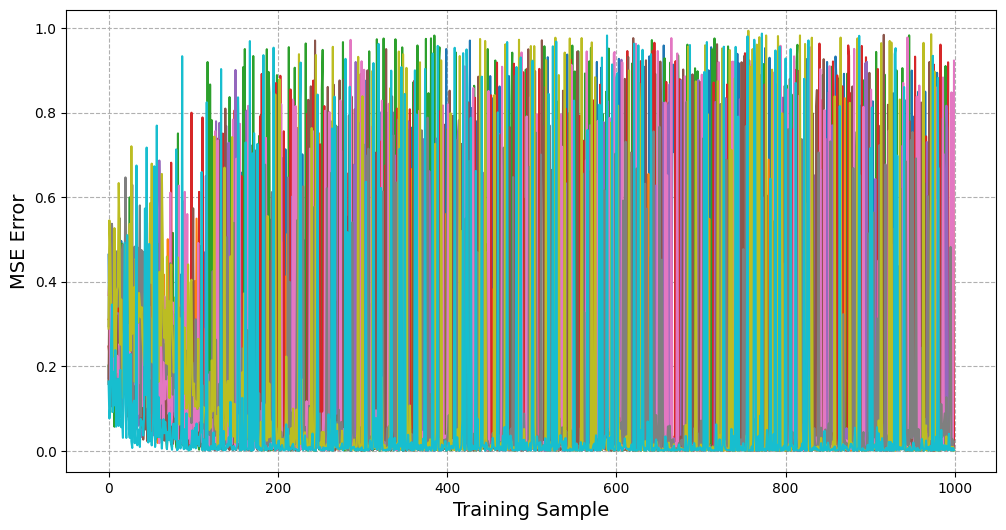

Evaluating Test Data: 100%|██████████| 1000/1000 [00:01<00:00, 509.99it/s]


[array([0.19450138, 0.13657101, 0.1069875 , 0.15890925, 0.22463709,
        0.1275808 , 0.09558484, 0.47714814, 0.04776287, 0.03732067]),
 array([0.11116775, 0.25103722, 0.07589512, 0.04546442, 0.09559634,
        0.03668633, 0.14241777, 0.07099268, 0.08091615, 0.03584891]),
 array([0.14814496, 0.48310677, 0.13081576, 0.12536005, 0.16436753,
        0.2464915 , 0.12045792, 0.22757109, 0.12332114, 0.10654483]),
 array([0.04854868, 0.03046317, 0.02343312, 0.028449  , 0.04200176,
        0.01887622, 0.04208238, 0.11085575, 0.03186488, 0.02347522]),
 array([0.20771041, 0.12818054, 0.12068481, 0.16367001, 0.38125066,
        0.16618992, 0.12605822, 0.35961391, 0.15735244, 0.22163727]),
 array([0.10159567, 0.39775168, 0.06760725, 0.06105418, 0.10825207,
        0.11243726, 0.07059809, 0.17039742, 0.08420887, 0.05664647]),
 array([0.1414932 , 0.10104373, 0.11625526, 0.10183124, 0.29080093,
        0.12531898, 0.09785629, 0.30582266, 0.08876032, 0.11316697]),
 array([0.07938181, 0.0760396 , 0.

In [19]:
############################## Build network ##############################

# layer_sequence = [input_shape, 'ReLU', 392, 'ReLU', 196, 'ReLU', 98, 'ReLU', 49, 'sigmoid', output_shape]
layer_sequence = [input_shape, 'relu', 100, 'sigmoid', output_shape] # initialize the layer sequences and corresponding activations

loss_function = 'MSE' # declare the loss function

nn = NN(layer_sequence, loss_function) # Build a model 

################################# Run it ##################################

nn.train(x_train, y_train, epochs = 1, batch_size = 5, epsilon = 0.01, visualize = True)

################################# Testing ##################################

nn.evaluate(x_test)

# nn.save_model(out_dir="../../temp/saved_models", filename="model")

# Comparison of Different Loss Functions:

In [ ]:
########################### Training Data Prep ###########################

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))
x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

num_data_pts = 1000

x_train = x_train[0:num_data_pts]
y_train = One_Hot_Encode(y_train[0:num_data_pts])

input_shape = x_train[0].size
output_shape = y_train[0].size

########################### Testing Data Prep ############################

num_test_evals = 1000

x_test = x_test[0:num_test_evals]
y_test = One_Hot_Encode(y_test[0:num_test_evals])

##########################################################################

In [ ]:
# layer_sequence = [input_shape, 'ReLU', 392, 'ReLU', 196, 'ReLU', 98, 'ReLU', 49, 'sigmoid', output_shape]
layer_sequence = [input_shape, 'ReLU', 100, 'sigmoid', output_shape] # initialize the layer sequences and corresponding activations


##########################################################################
############################## Build network #############################
##########################################################################
loss_function = 'MSE'

nn1 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn1.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = False)

##########################################################################
##########################################################################
##########################################################################

##########################################################################
############################## Build network #############################
##########################################################################

loss_function = 'MAE'

nn2 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn2.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = False)

##########################################################################
##########################################################################
##########################################################################

##########################################################################
############################## Build network #############################
##########################################################################

loss_function = 'MAPE'

nn3 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn3.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = False)

##########################################################################
##########################################################################
##########################################################################

##########################################################################
############################## Build network #############################
##########################################################################

loss_function = 'MSLE'

nn4 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn4.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = False)

##########################################################################
##########################################################################
##########################################################################

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (16,8))
            
ax[0][0].plot(nn1.training_err, label = '%s' % str(nn1.loss_func)) # to visualize error over time
ax[0][0].set_xlabel('Training Sample', fontsize = 14)
ax[0][0].set_ylabel('%s Error' % nn1.loss_func_label, fontsize = 14)
ax[0][0].grid(linestyle = '--')
ax[0][0].legend(fontsize = 12)

ax[0][1].plot(nn2.training_err, label = '%s' % str(nn2.loss_func)) # to visualize error over time
ax[0][1].set_xlabel('Training Sample', fontsize = 14)
ax[0][1].set_ylabel('%s Error' % nn2.loss_func_label, fontsize = 14)
ax[0][1].grid(linestyle = '--')
ax[0][1].legend(fontsize = 12)

ax[1][0].plot(nn3.training_err, label = '%s' % str(nn3.loss_func)) # to visualize error over time
ax[1][0].set_xlabel('Training Sample', fontsize = 14)
ax[1][0].set_ylabel('%s Error' % nn3.loss_func_label, fontsize = 14)
ax[1][0].grid(linestyle = '--')
ax[1][0].legend(fontsize = 12)

ax[1][1].plot(nn4.training_err, label = '%s' % str(nn4.loss_func)) # to visualize error over time
ax[1][1].set_xlabel('Training Sample', fontsize = 14)
ax[1][1].set_ylabel('%s Error' % nn4.loss_func_label, fontsize = 14)
ax[1][1].grid(linestyle = '--')
ax[1][1].legend(fontsize = 12)

plt.show()

# Example of Classification with MNIST (only 2 labels):

In [ ]:
first_number = 0
second_number = 1

################################# Params #################################
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_zeros = y_train == first_number
train_ones = y_train == second_number

x_train = np.array(list(x_train[train_zeros]) + list(x_train[train_ones]))
y_train = np.array(list(y_train[train_zeros]) + list(y_train[train_ones]))

x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))

x_train, y_train = unison_shuffled_copies(x_train, y_train)

x_train, y_train = x_train[:1000], One_Hot_Encode(y_train[:1000])

test_zeros = y_test == first_number
test_ones = y_test == second_number

x_test = np.array(list(x_test[test_zeros]) + list(x_test[test_ones]))
y_test = np.array(list(y_test[test_zeros]) + list(y_test[test_ones]))

x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

x_test, y_test = unison_shuffled_copies(x_test, y_test)

x_test, y_test = x_test[:1000], One_Hot_Encode(y_test[:1000])

input_shape = x_train[0].size
output_shape = y_train[0].size


############################## Build network ##############################

# layer_sequence = [input_shape, 'ReLU', 392, 'ReLU', 196, 'ReLU', 98, 'ReLU', 49, 'sigmoid', output_shape]
layer_sequence = [input_shape, 'ReLU', 100, 'sigmoid', output_shape]

loss_function = 'MSE'
# loss_function = 'Binary Cross-Entropy'

nn = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn.train(x_train, y_train, batch_size = 5, epsilon = 0.1, visualize = True)

################################# Testing ##################################

nn.evaluate(x_test, y_test)

# Compare to TensorFlow

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

In [ ]:
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0



(x_train, y_train), (x_test, y_test) = mnist.load_data()


zeros_train = y_train == 0
x_train_zeros, y_train_zeros = list(x_train[zeros_train]), list(y_train[zeros_train])
zeros_test = y_test == 0
x_test_zeros, y_test_zeros = list(x_test[zeros_test]), list(y_test[zeros_test])

ones_train = y_train == 1
x_train_ones, y_train_ones = list(x_train[ones_train]), list(y_train[ones_train])
ones_test = y_test == 1
x_test_ones, y_test_ones = list(x_test[ones_test]), list(y_test[ones_test])


x_train, y_train = np.array(x_train_zeros + x_train_ones), np.array(y_train_zeros + y_train_ones)
x_test, y_test = np.array(x_test_zeros + x_test_ones), np.array(y_test_zeros + y_test_ones)


# shuffle arrays

x_train, y_train = unison_shuffled_copies(x_train, y_train)
x_test, y_test = unison_shuffled_copies(x_test, y_test)

x_train = (x_train / 255.)
x_test = (x_test / 255.)

print(x_train.shape)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100, activation='relu'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='sigmoid')
])
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, batch_size= 5, epochs=1)